In [2]:
import numpy as np 
import pandas as pd
import xarray as xr
import openpyxl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


In [3]:
path="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/MeraLafinal2013_24.xlsx"
xl_data=pd.ExcelFile(path)                           
#print(xl_data)                                       

In [4]:
dfs = {sheet_name: xl_data.parse(sheet_name)      #dfs = dictionnaire 
       for sheet_name in xl_data.sheet_names}
DataMeraLa=dfs['MeraLa2013_23']                   #DataMeraLa = datarame panda/ [un tableau] ( pandas.core.frame.DataFrame ) 

In [5]:

NameVarsM=['Time','Tair','RH','u','Direction','SWin','SWout','LWin','LWout','Patm']


In [6]:
UnitVarsM=['data/hour','C','%','m/s','degrees','W/m2','W/m2','W/m2','W/m2','hPa']


In [7]:
dfileM= pd.DataFrame(data=DataMeraLa.loc[4:])   #nouveau Tableau/ dataframe contenant toutes les informations mais pas *rangé*
#dfileM

In [8]:
dfM=pd.DataFrame(dfileM.values, columns=NameVarsM) #Encore un nouveau Tableau avec les noms et unités de chaque colonnes bien définies 
#dfM

In [9]:
Tair_ar=[float(i) for i in dfM.Tair.values]   #Convertit les données en float utilisables 

In [10]:
#Pour l'utilisation des données avec xarray, redéfinitions des variables en prenant en compte la fréquence à laquelle les données sont prises ( ici 30 min ) 
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = dfM.Time.values[0], dfM.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    return ds 
    
TM=NewTime('Tair',Tair_ar,'30min')

#Ecriture pour une seule variable
#NameVar="Tair"; Var_ar=Tair_ar
#start, end = df.Time.values[0], df.Time.values[-1]
#time = pd.date_range(start, end, freq='30min')
#ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})


In [11]:
daily_meanTM=TM.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanTM=daily_meanTM.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanTM=monthly_meanTM.resample(time='YE').mean()
#daily_meanTM

#Variables jusqu'ici: TM, daily_meanTM, monthly_meanTM, yearly_meanTM: que des Xarray.Dataset

In [12]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))



TM_premonmonth = seasonsdata(monthly_meanTM, 'MAM')  #33 Points de données, 1 valeur moyenne de T pour chaque mois de la saison considérée
TM_monmonth = seasonsdata(monthly_meanTM, 'JJAS')    #44 Points
TM_postmonmonth = seasonsdata(monthly_meanTM, 'ON')  #23 Points
TM_hivermonth = seasonsdata(monthly_meanTM, 'DJF')   #33 Points 


In [13]:
TM_premon = seasonsdata(monthly_meanTM, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
TM_mon = seasonsdata(monthly_meanTM, 'JJAS').resample(time='YE').mean()
TM_postmon =  seasonsdata(monthly_meanTM, 'ON').resample(time='YE').mean()
TM_hiver  = seasonsdata(monthly_meanTM, 'DJF').resample(time='YE').mean()

In [14]:
xtime=np.arange(2014,2024+1,1)
xtime_premon=np.arange(2014,2024+1,1)
xtime_mon=np.arange(2014,2024+1,1)
xtime_postmon =np.arange(2013,2024+1,1)
xtime_hiver=np.arange(2013,2024+1,1)
#print(xtime_premon, xtime_postmon, xtime_mon, xtime_hiver)

In [15]:
linTM_mon = stats.linregress(xtime_mon,TM_mon['Tair'].values)
linTM_postmon = stats.linregress(xtime_postmon,TM_postmon['Tair'].values)
linTM_premon = stats.linregress(xtime_premon,TM_premon['Tair'].values)
linTM_hiver = stats.linregress(xtime_hiver,TM_hiver['Tair'].values)

In [16]:
linTM_mon, linTM_hiver, linTM_postmon, linTM_premon

(LinregressResult(slope=np.float64(0.08378049958678616), intercept=np.float64(-167.22423155054898), rvalue=np.float64(0.6606308140882217), pvalue=np.float64(0.026912865389777014), stderr=np.float64(0.031734788896272986), intercept_stderr=np.float64(64.07261737189074)),
 LinregressResult(slope=np.float64(-0.12420926053808075), intercept=np.float64(241.8836282957653), rvalue=np.float64(-0.3085823199856021), pvalue=np.float64(0.3291196920008769), stderr=np.float64(0.12107478343101154), intercept_stderr=np.float64(244.389807751281)),
 LinregressResult(slope=np.float64(0.06645577208350664), intercept=np.float64(-137.859221504735), rvalue=np.float64(0.2814244635101707), pvalue=np.float64(0.37554745383623567), stderr=np.float64(0.0716561681699029), intercept_stderr=np.float64(144.6381869699102)),
 LinregressResult(slope=np.float64(0.06458697892907575), intercept=np.float64(-135.48120931486866), rvalue=np.float64(0.24521477085860424), pvalue=np.float64(0.4673715950585775), stderr=np.float64(0.

In [17]:
print(linTM_mon.slope, linTM_hiver.slope, linTM_postmon.slope, linTM_premon.slope)

0.08378049958678616 -0.12420926053808075 0.06645577208350664 0.06458697892907575


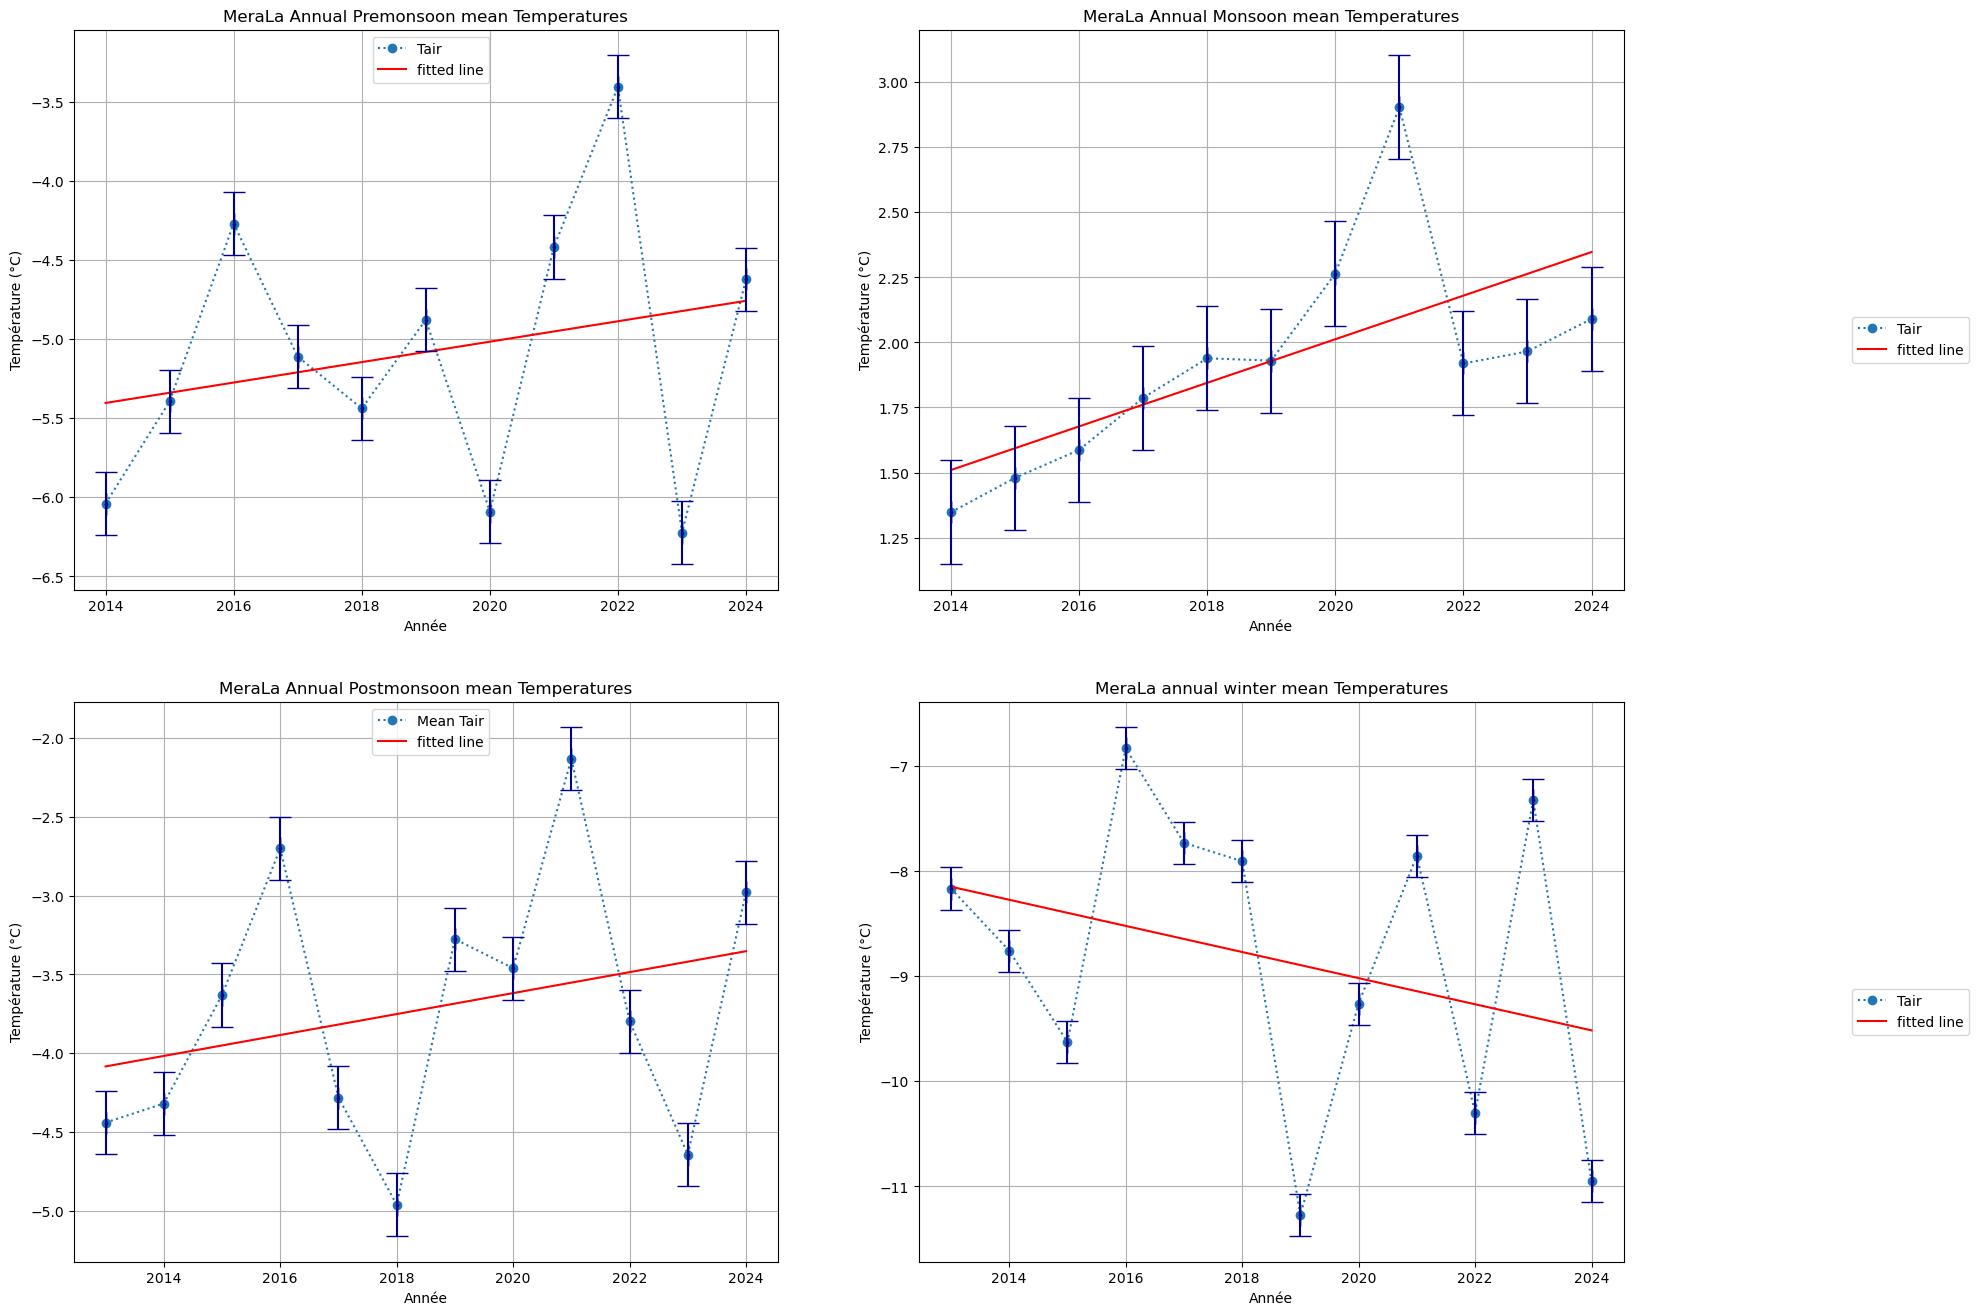

In [18]:
fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(xtime_premon, TM_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair')
ax1.plot(xtime_premon, linTM_premon.intercept + linTM_premon.slope*xtime_premon, 'r', label='fitted line')
ax1.errorbar(xtime_premon,TM_premon['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MeraLa Annual Premonsoon mean Temperatures')
ax1.set_xlabel('Année')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(xtime, TM_mon['Tair'].values,linestyle=':', marker= 'o', label='Tair')
ax2.plot(xtime, linTM_mon.intercept + linTM_mon.slope*xtime, 'r', label='fitted line')
ax2.errorbar(xtime,TM_mon['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax2.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax2.set_title('MeraLa Annual Monsoon mean Temperatures')
ax2.set_xlabel('Année')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(xtime_postmon, TM_postmon['Tair'].values,linestyle=':', marker= 'o', label='Mean Tair')
ax3.plot(xtime_postmon, linTM_postmon.intercept + linTM_postmon.slope*xtime_postmon, 'r', label='fitted line')
ax3.errorbar(xtime_postmon,TM_postmon['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('MeraLa Annual Postmonsoon mean Temperatures')
ax3.set_xlabel('Année')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(xtime_hiver, TM_hiver['Tair'].values,linestyle=':', marker= 'o', label='Tair')
ax4.plot(xtime_hiver, linTM_hiver.intercept + linTM_hiver.slope*xtime_hiver, 'r', label='fitted line')
ax4.errorbar(xtime_hiver,TM_hiver['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('MeraLa annual winter mean Temperatures')
ax4.set_xlabel('Année')
ax4.set_ylabel('Température (°C)')
ax4.grid()

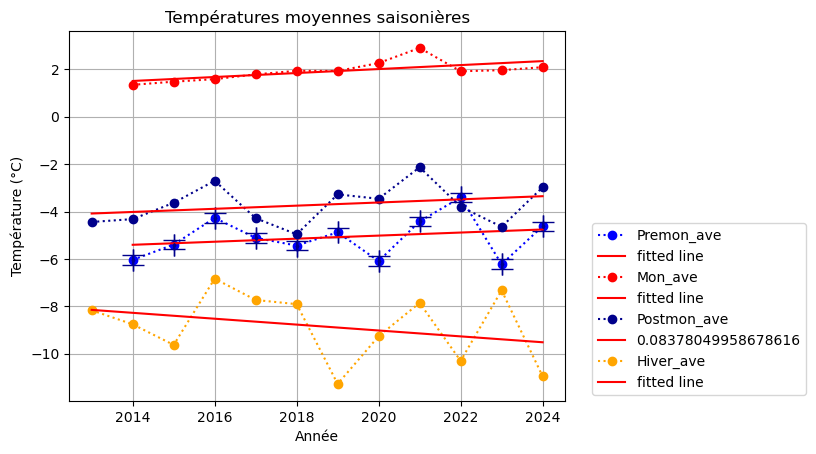

In [19]:
#TEMPERATURES MOYENNES SAISONIERES PAR ANS
plt.plot(xtime_premon, TM_premon['Tair'].values,
         color='blue',linestyle=':',label='Premon_ave',marker='o')
plt.errorbar(xtime_premon,TM_premon['Tair'].values, xerr=0, yerr=0.2, marker="d",
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
plt.plot(xtime_premon, linTM_premon.intercept + linTM_premon.slope*xtime_premon, 'r', label='fitted line')
plt.plot(xtime, TM_mon['Tair'].values,
         color='red',linestyle=':',label='Mon_ave', marker='o')
plt.plot(xtime, linTM_mon.intercept + linTM_mon.slope*xtime, 'r', label='fitted line')
plt.plot(xtime_postmon, TM_postmon['Tair'].values,
         color='darkblue',linestyle=':',label='Postmon_ave', marker='o')
plt.plot(xtime_postmon, linTM_postmon.intercept + linTM_postmon.slope*xtime_postmon, 'r', label=linTM_mon.slope)
plt.plot(xtime_hiver, TM_hiver['Tair'].values,
         color='orange',linestyle=':',label='Hiver_ave', marker='o')
plt.plot(xtime_hiver, linTM_hiver.intercept + linTM_hiver.slope*xtime_hiver, 'r', label='fitted line')
plt.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
plt.title('Températures moyennes saisonières')
plt.xlabel('Année')
plt.ylabel('Température (°C)')
plt.grid(True)

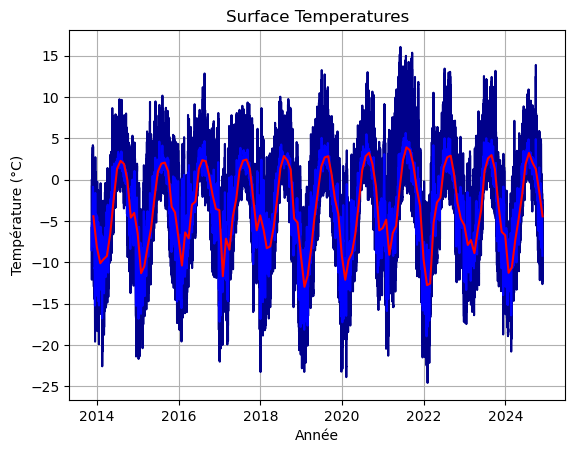

In [20]:
#VARIATIONS DES TEMPERATURES DE SURFACES  
#TM.Tair.plot()
plt.plot(TM.time,TM['Tair'].values,
    color='darkblue',linestyle='-',label='Tair')
plt.plot(daily_meanTM.time,daily_meanTM['Tair'].values,
    color='blue',linestyle='-',label='Tair')
plt.plot(monthly_meanTM.time,monthly_meanTM['Tair'].values,
    color='r',linestyle='-',label='Tair')
plt.title('Surface Temperatures')
plt.xlabel('Année')
plt.ylabel('Température (°C)')
plt.grid(True)

In [21]:
Tannual=daily_meanTM.groupby('time.dayofyear').mean()


In [22]:
Tannual


<xarray.Dataset> Size: 6kB
Dimensions:    (dayofyear: 366)
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    Tair       (dayofyear) float64 3kB -10.99 -11.84 -11.71 ... -10.65 -9.908

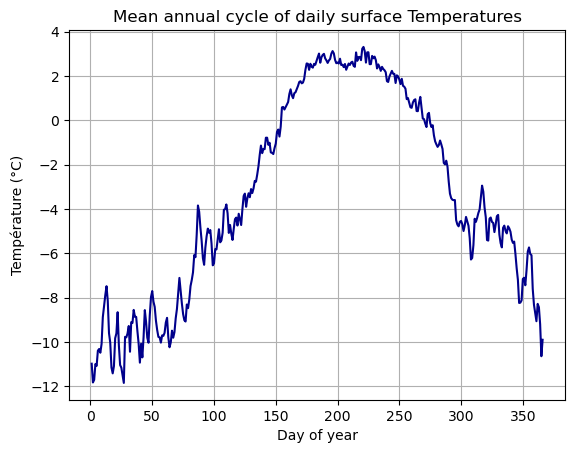

In [23]:
plt.plot(Tannual.dayofyear,Tannual.Tair,
         
    color='darkblue',linestyle='-',label='Tair')
plt.title('Mean annual cycle of daily surface Temperatures')
plt.xlabel('Day of year')
plt.ylabel('Température (°C)')

plt.grid(True)